# Event Times Sampler

*PyDTS* provides `EventTimesSampler` (ETS) class for sampling discrete-time survival data with competing risks and right censoring under the log-link model. In the following, we present an example of how to use the ETS to sample discrete-time with competing events and right censoring data.

## Covariates

A user-supplied covariates should be passed to ETS. For example, consider a setting with $n=10,000$ independent observations and the following covariates

$$
Z_1 \sim  \mbox{Bernoulli(0.5)} 
$$

$$
Z_2 | Z_1 \sim \mbox{Normal}(72 + 10 Z_1, 12) \, ,
$$

and

$$
Z_3 \sim  1+\mbox{Poisson}(4) \, .
$$

Any sampling framework can be used for creating the covariates' dataframe. For example:

In [1]:
import numpy as np
import pandas as pd

n_observations = 10000

observations_df = pd.DataFrame(columns = ['Z1', 'Z2', 'Z3'])
observations_df['Z1'] = np.random.binomial(n = 1, p = 0.5, 
                                           size = n_observations)
Z1_zero_index = observations_df.loc[observations_df['Z1'] == 0].index
observations_df.loc[Z1_zero_index, 'Z2'] = np.random.normal(loc = 72, scale = 12, 
                     size = n_observations - observations_df['Z1'].sum())
Z1_one_index = observations_df.loc[observations_df['Z1'] == 1].index
observations_df.loc[Z1_one_index, 'Z2'] = np.random.normal(loc = 82, scale = 12, 
                     size = observations_df['Z1'].sum())
observations_df['Z3'] = 1 + np.random.poisson(lam = 4, size = n_observations)

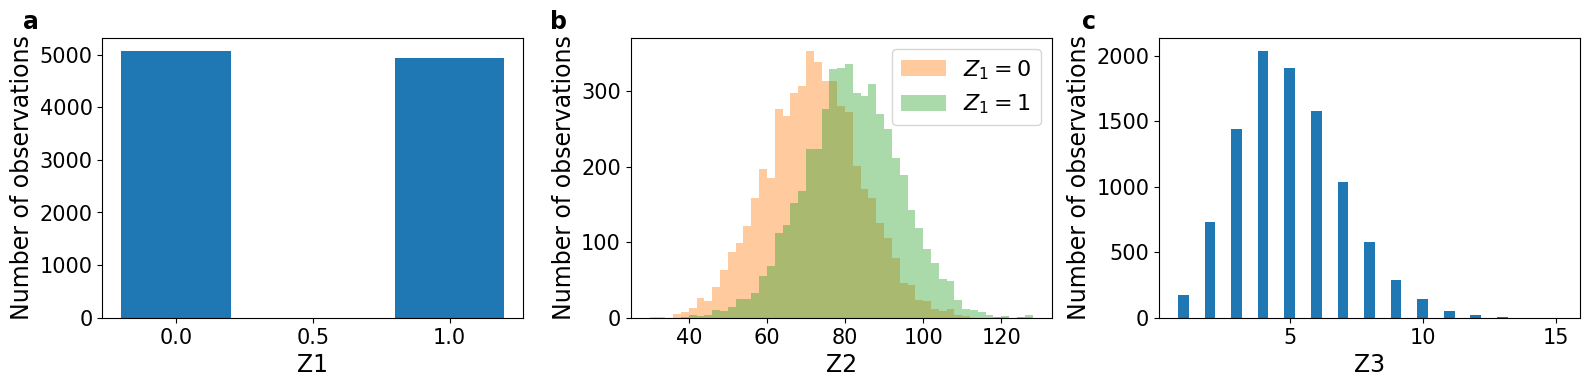

In [2]:
from pydts.examples_utils.plots import plot_sampled_covariates_figure 
plot_sampled_covariates_figure(observations_df, fname='tmp.png')

## Event Times

The ETS function assumes that the possible failure times are $1, \ldots, d$, and the user should supply the value of $d$. Clearly, the time intervals can be irregularly spaced and variable in size. For instance, discrete-time categories 1, 2, and 3 could correspond to specific days like Tuesday, Thursday, and Friday-Sunday, respectively. In the current example, we chose $d=7$. 

For the competing-events setting the user should decide on the number of competing events, and the values of model parameters, $\alpha_{jt}$, $\beta_j$, $t=1,\ldots,d$, $j=1,\ldots,M$. For example, consider $M=2$ competing events and

$$
\alpha_{1t} =  -1 - 0.3 \log t \, , \, t =1, \ldots, 7 
$$

$$
\alpha_{2t} =  -1.75 - 0.15 \log t \, , \, t=1, \ldots, 7
$$

$$
\beta^\top_{1} =  (-\log 0.8, -\log 1.4, -\log 3)
$$

$$
\beta^\top_{2} = (-\log 1, -\log 0.95, -\log 2) \, .
$$

All together, the ETS function is defined for sampling event-type and event-time, and adding it to the data frame, as follows:

In [3]:
from pydts.data_generation import EventTimesSampler

ets = EventTimesSampler(d_times=7, j_event_types=2)
coefficients_dict = {
    "alpha": {
        1: lambda t: -1 - 0.3 * np.log(t),
        2: lambda t: -1.75 - 0.15 * np.log(t),
    },
    "beta": {
        1: -1 * np.log([0.8, 1.4, 3]),
        2: -1 * np.log([1, 0.95, 2]),
}}
observations_df = ets.sample_event_times(observations_df, coefficients_dict)

If the sampled covariates and parameters' values lead to impossible survival probabilities (i.e., negative or greater than one), the sampling process will be terminated with an error message. In such scenarios, it may be useful to adjust the coefficients or constrain extreme values of the covariates to ensure that the probabilities are appropriate and the sampling process is executed successfully.

## Censoring Time

Two types of right censoring are implemented in *PyDTS*, administrative and random right censoring. For administrative censoring, $J_i=0$ and $T_i = d + 1$. These are the default values of observations for which the sampled event type was observed to be greater than $d$. Random right censoring is optional and could be either dependent or independent of the covariates. For example, assume

$$
\Pr (C_i = t) = 0.05 \quad  t=1, \ldots, 7 \, .
$$

The censoring times can be sampled by

In [4]:
prob_lof_at_t = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
observations_df = ets.sample_independent_lof_censoring(observations_df, 
                                                       prob_lof_at_t)

To generate right-censoring times that depend on the covariates, the user should supply to censoring hazard function, $\lambda_c(t|Z)$ in the form of the logit-link model. For example,

In [5]:
censoring_coef_dict = {
    "alpha": {
        0: lambda t: -0.3 - 0.3 * np.log(t),
    },
    "beta": {
        0: -1 * np.log([8, 0.95, 6]),
}}
observations_df = ets.sample_hazard_lof_censoring(observations_df, 
        censoring_coef_dict)

## Updating the Observations

Finally, the observed data should be updated by $X_i = min(T_i, C_i)$ and $J_i$ as follows

In [6]:
observations_df = ets.update_event_or_lof(observations_df)

The first observations of the sampled data are

In [7]:
observations_df.head(30)

,Z1,Z2,Z3,J,T,C,X
0,1,77.707214,4,2,3,8,3
1,0,79.17863,6,2,5,8,5
2,0,66.023722,5,0,8,8,8
3,1,89.672794,5,2,2,8,2
4,0,76.386179,5,0,8,8,8
5,1,79.180418,3,2,4,8,4
6,1,79.500548,5,2,5,8,5
7,1,89.930194,3,2,1,8,1
8,0,68.328199,4,2,2,8,2
9,1,92.693606,8,2,4,8,4


## References

[1] Meir, Tomer, Gutman, Rom, and Gorfine, Malka, "PyDTS: A Python Package for Discrete-Time Survival Analysis with Competing Risks" (2022)